# Transfer learning and other tricks

In [79]:
import math, torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt


In [80]:
transfer_model = models.resnet50(weights=True)

## Freezing params - except BatchNorm

In [81]:
for name, param in transfer_model.named_parameters():
    if ("bn" not in name):
        param.requires_grad = False 
        

## Replacing the classifier (fc)

In [82]:
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 500), 
    nn.ReLU(), 
    nn.Dropout(), 
    nn.Linear(500, 2))

## Training again 

In [83]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device is: ", device) 
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

Device is:  cuda


In [84]:
def check_image(path):
    try:
        img = Image.open(path)
        return True 
    except:
        return False

In [85]:
img_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data_path = "./cat-dog-data/train"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=img_transforms, is_valid_file=check_image)
val_data_path = "./cat-dog-data/val"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms, is_valid_file=check_image)



In [86]:
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
print(len(val_data_loader.dataset))

200


In [87]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch 
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs) # [batch, num_classes]
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq( torch.max(F.softmax(output, dim=1), dim=1)[1], targets ).view(-1) 
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy: {:.2f}".format(epoch, training_loss, valid_loss, num_correct/num_examples))

In [88]:
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=50, device=device)

Epoch: 0, Training Loss: 0.62, Validation Loss: 0.56, accuracy: 0.71
Epoch: 1, Training Loss: 0.36, Validation Loss: 0.48, accuracy: 0.81
Epoch: 2, Training Loss: 0.35, Validation Loss: 0.42, accuracy: 0.82
Epoch: 3, Training Loss: 0.22, Validation Loss: 0.51, accuracy: 0.82
Epoch: 4, Training Loss: 0.17, Validation Loss: 0.52, accuracy: 0.84
Epoch: 5, Training Loss: 0.10, Validation Loss: 0.51, accuracy: 0.83
Epoch: 6, Training Loss: 0.19, Validation Loss: 0.57, accuracy: 0.81
Epoch: 7, Training Loss: 0.15, Validation Loss: 0.70, accuracy: 0.83
Epoch: 8, Training Loss: 0.27, Validation Loss: 0.67, accuracy: 0.83
Epoch: 9, Training Loss: 0.30, Validation Loss: 0.78, accuracy: 0.82
Epoch: 10, Training Loss: 0.24, Validation Loss: 0.87, accuracy: 0.84
Epoch: 11, Training Loss: 0.24, Validation Loss: 0.80, accuracy: 0.81
Epoch: 12, Training Loss: 0.21, Validation Loss: 0.88, accuracy: 0.83
Epoch: 13, Training Loss: 0.09, Validation Loss: 0.90, accuracy: 0.82
Epoch: 14, Training Loss: 0.05

## LR Finder - at where loss decrease the most

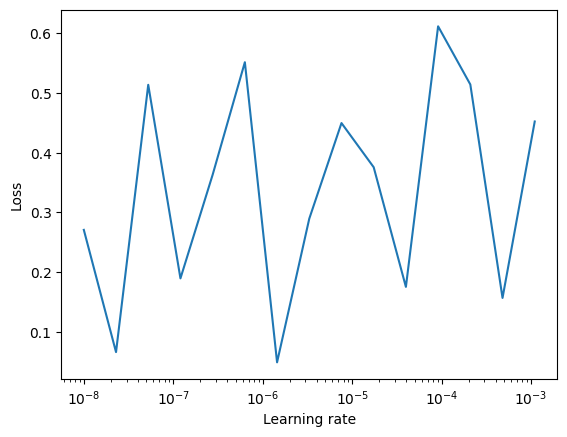

In [90]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1/number_in_epoch)
    lr = init_value 
    optimizer.param_groups[0]["lr"] = lr # KEY: to specify which learning-rate being used
    best_loss = 0.0
    batch_num = 0 
    losses = []
    lrs = []
    for data in train_loader:
        batch_num += 1 
        inputs, targets = data 
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss_val = loss.item()
        
        # Crash out if loss exlodes
        if batch_num>1 and loss>40*best_loss:
            if len(lrs) > 20:
                return lrs[10:-5], losses[10:-5]
            else:
                return lrs, losses
                
        if loss_val < best_loss or batch_num == 1:
            best_loss = loss 
        losses.append(loss_val)
        lrs.append(lr)
        loss.backward()
        optimizer.step()
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if len(lrs) > 20:
        return lrs[10:-5], losses[10:-5]
    else:
        return lrs, losses

(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(), optimizer, train_data_loader, device=device)
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()


## Differential Learning Rates

In [92]:
found_lr = 1e-2
optimizer = optim.Adam([
    {'params': transfer_model.layer4.parameters(), 'lr': found_lr/3},
    {'params': transfer_model.layer3.parameters(), 'lr': found_lr/9}
], lr=found_lr)

In [93]:
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

## Torchvision transforms

In [95]:
from PIL import Image 
import matplotlib.pyplot as plt
from torchvision import transforms

In [98]:
img = Image.open("cat-dog-data/train/cat/1.jpg")


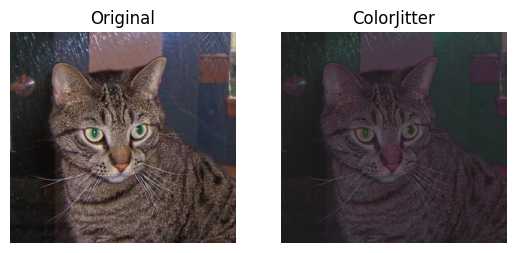

In [113]:
color_jitter = transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
jittered_img = color_jitter(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(jittered_img)
plt.title("ColorJitter")
plt.axis("off")

plt.show()

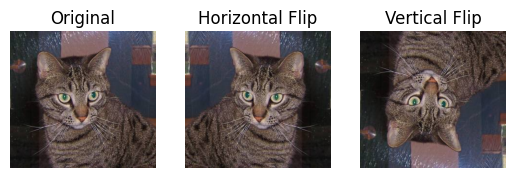

In [112]:
hflip = transforms.RandomHorizontalFlip(p=1.0)
vflip = transforms.RandomVerticalFlip(p=1.0)
img_h = hflip(img)
img_v = vflip(img)

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_h)
plt.title("Horizontal Flip")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_v)
plt.title("Vertical Flip")
plt.axis("off")

plt.show()

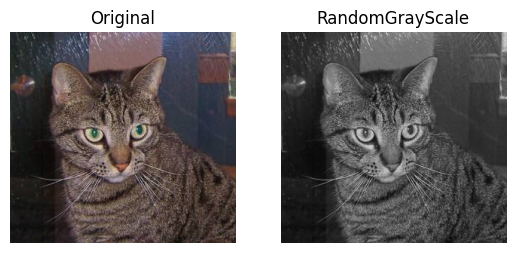

In [111]:
to_gray = transforms.RandomGrayscale(p=1.0)
img_gray = to_gray(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_gray)
plt.title("RandomGrayScale")
plt.axis("off")

plt.show()

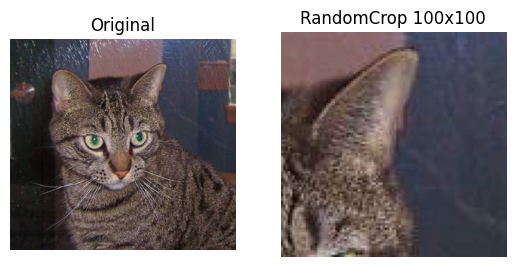

In [116]:
rcrop = transforms.RandomCrop(size=(100,100), padding=None, pad_if_needed=False, fill=0, padding_mode='constant')
img_crop = rcrop(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_crop)
plt.title("RandomCrop 100x100")
plt.axis("off")

plt.show()

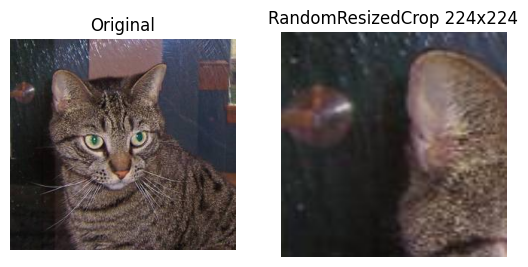

In [120]:
rrcrop = transforms.RandomResizedCrop(
    size=224, # final output size [224,224] (last step we resize to this)
    scale=(0.08,1.0), # crop area is randomly selected between 8%-total-area and 100%-total-area (e.g. pick 80% area) 
    ratio=(0.75,1.3333), # width/height ratio is between 3/4 or 4/3
    interpolation=2)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

img_rr = rrcrop(img)
plt.subplot(1,2,2)
plt.imshow(img_rr)
plt.title("RandomResizedCrop 224x224")
plt.axis("off")

plt.show()


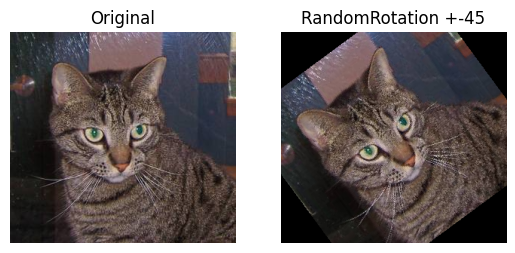

In [123]:
rotate = transforms.RandomRotation(degrees=45) # rotate [-45,45]
rotated_img = rotate(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(rotated_img)
plt.title("RandomRotation +-45")
plt.axis("off")

plt.show()


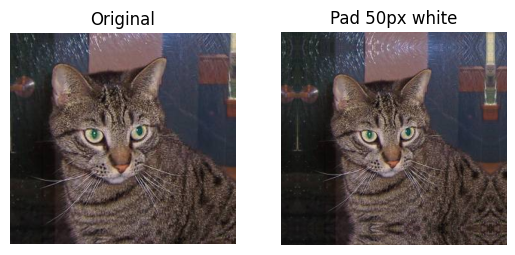

In [129]:
pad = transforms.Pad(25, fill=255, padding_mode="reflect") # fill white (255) 50-pixels left, 50 pixels right,...
padded_img = pad(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(padded_img)
plt.title("Pad 50px white")
plt.axis("off")

plt.show()

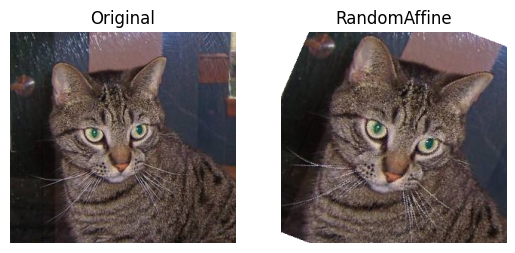

In [130]:
affine = transforms.RandomAffine(
    degrees=30, # randomly rotate between -30 and 30
    translate=(0.1, 0.1), # shift randomly width 0%-10%; shift randomly height 0%-10%
    scale=(0.8, 1.2), # zoom randomly between 80%-120%
    shear=10, # shear angle; shear in X direction randomly -10/10 pixels if one number; shear in X direction randomly x1/x2 if two numbers; shear in X/Y randomly if 4 numbers
    fill=255 # fill with White color
)
img_affine = affine(img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_affine)
plt.title("RandomAffine")
plt.axis("off")

plt.show()
    